In [2]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import env, acquire, summarize, prepare

### 1. Acquire data from mall_customers in mysql database

In [3]:
mall = acquire.get_mall_data()
mall.shape

(200, 5)

In [4]:
mall.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
mall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 9.4+ KB


### 2. Summarize data (include distributions and descriptive statistics)

In [9]:
# Get the df having numeric variables only

mall_num = summarize.num_df(mall)
mall_num.shape

(200, 4)

In [10]:
mall_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   customer_id     200 non-null    int64
 1   age             200 non-null    int64
 2   annual_income   200 non-null    int64
 3   spending_score  200 non-null    int64
dtypes: int64(4)
memory usage: 17.8 KB


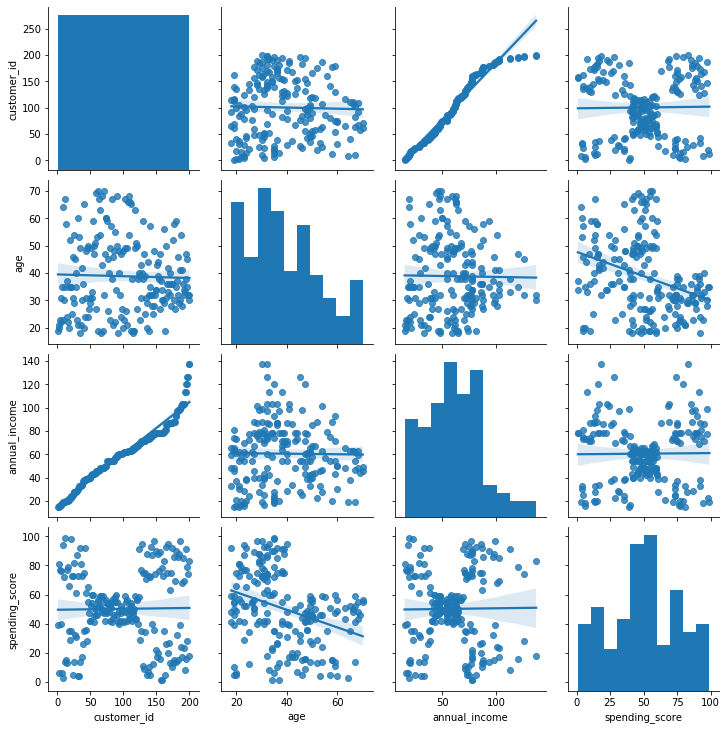

In [8]:
# Pairplot the numeric variables

summarize.plot_variable_pairs(mall_num)

In [11]:
# Get the df having object columns only

mall_obj = summarize.obj_df(mall)
mall_obj.shape

(200, 1)

In [12]:
# Display the unique values of the object cols

summarize.sum_obj_cols(mall_obj)

,dtypes,unique_values
gender,object,2


In [13]:
# Display the counts of the unique values of each object col

summarize.obj_value_counts(mall_obj)

Female    112
Male       88
Name: gender, dtype: int64
----------------------------------------------------------------------------------------------------
